# AML flow cytometry analysis

In [1]:
import numpy as np
import torch
from torch.autograd import Variable
from fcvae_dataset import load_data
from fcvae_model import VAE, Encoder, Decoder, Classifier
from fcvae_trainer import fcTrainer
from fcvae_plot import CellPlotter2D, plot_joint_aml, plot_shared_markers_aml, plot_imputed_values_set
from umap import UMAP
import flowkit as fk
import glob

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Torch version:", torch.__version__)
print("Device:", device)

Torch version: 1.2.0
Device: cpu


## 1. Load data

In [40]:
filepath1 = "/scratch/cs/csb/projects/single-cell-analysis/FCM/AML_FCM/data_files/"

batch_size = 256         # number of data points in each batch
n_epochs = 20           # times to run the model on complete data
input_dim = 7     # size of each input
hidden_dim = 128        # hidden dimension
latent_dim = 4        # latent vector dimension
lr = 1e-3              # learning rate
n_head = 4
n_shared = 3
missing = 12

datasets = load_data(filepath1)

input_dim_list = []
output_dim_list = []
train_iterators = []
test_iterators = []
train_cells = 0
test_cells = 0
for tube in datasets:
    input_dim_list.append(len(tube[0].columns))
    output_dim_list.append(len(tube[0].columns)+missing)
    train_iterators.append(tube[3])
    test_iterators.append(tube[4])
    train_cells += tube[1].nb_cells
    test_cells += tube[2].nb_cells

N_train = int(train_cells/n_head)
N_test = int(test_cells/n_head)
print('Training set size:', N_train)
print('Test set size:', N_test)

Training set size: 27000
Test set size: 3000


## 2. Create a model

In [41]:
# Encoder
encoder = Encoder(n_head, input_dim_list, hidden_dim, latent_dim)

# Decoder
decoder = Decoder(latent_dim, hidden_dim, output_dim_list, n_head)

# VAE
model = VAE(encoder, decoder).to(device)

# Discriminator
discriminator = Classifier(latent_dim, hidden_dim, n_head) 

print("n_tubes:", n_head)
print("n_shared:", n_shared)
print("n_other:", missing)
print("output_dim:", output_dim_list[0])
print("encoder_dims:", input_dim_list)

n_tubes: 4
n_shared: 3
n_other: 12
output_dim: 19
encoder_dims: [7, 7, 7, 7]


## 3. Train the model

In [42]:
# Create trainer
trainer = fcTrainer(
            model,
            discriminator,
            train_loaders = train_iterators,
            test_loaders = test_iterators,
            N_train = N_train,
            N_test = N_test,
            dloss_weight = 10,
            device = device,
            n_epochs = n_epochs,
            print_frequency = 1,
            optimizer_kwargs = dict(lr = lr)
)

05/03/2020 11:12:49 [INFO]: Creating a trainer on device `cpu`


In [43]:
# Run training
trainer.train()

05/03/2020 11:12:52 [INFO]: TRAINING STARTED (n_epochs = 20).
05/03/2020 11:13:21 [INFO]: Epoch: 00, VAE loss: (157.8947, 75.00265), Discriminator loss: (0.62139, 0.82407)
05/03/2020 11:13:50 [INFO]: Epoch: 01, VAE loss: (82.4693, 61.25522), Discriminator loss: (0.27549, 0.8871)
05/03/2020 11:14:19 [INFO]: Epoch: 02, VAE loss: (73.60668, 56.37685), Discriminator loss: (0.18835, 0.85036)
05/03/2020 11:14:48 [INFO]: Epoch: 03, VAE loss: (69.24319, 57.02274), Discriminator loss: (0.17428, 0.88652)
05/03/2020 11:15:17 [INFO]: Epoch: 04, VAE loss: (66.54752, 51.57028), Discriminator loss: (0.18743, 0.92642)
05/03/2020 11:15:47 [INFO]: Epoch: 05, VAE loss: (63.92165, 50.67182), Discriminator loss: (0.21347, 0.94368)
05/03/2020 11:16:16 [INFO]: Epoch: 06, VAE loss: (61.20313, 47.26561), Discriminator loss: (0.22537, 0.95268)
05/03/2020 11:16:45 [INFO]: Epoch: 07, VAE loss: (60.40627, 50.69369), Discriminator loss: (0.22785, 0.93814)
05/03/2020 11:17:15 [INFO]: Epoch: 08, VAE loss: (58.85883, 

## 4. Visualization

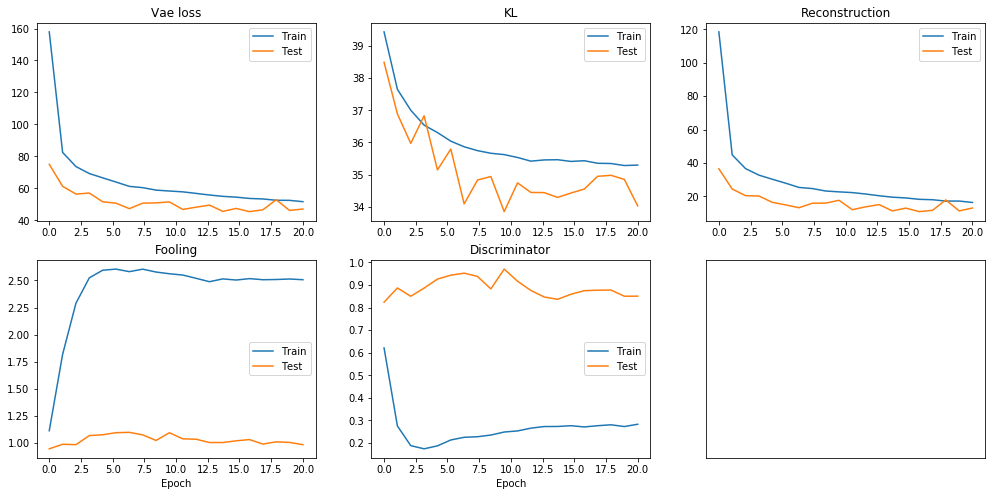

IndexError: list index out of range

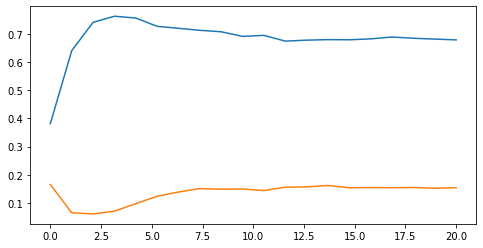

In [44]:
trainer.plot()
trainer.plot_probs()

/home/hiltunh3/.conda/envs/scvi/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../home/hiltunh3/.conda/envs/scvi/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


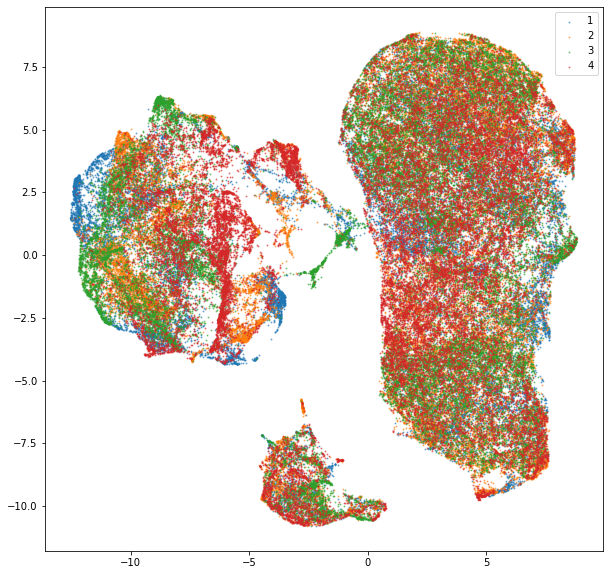

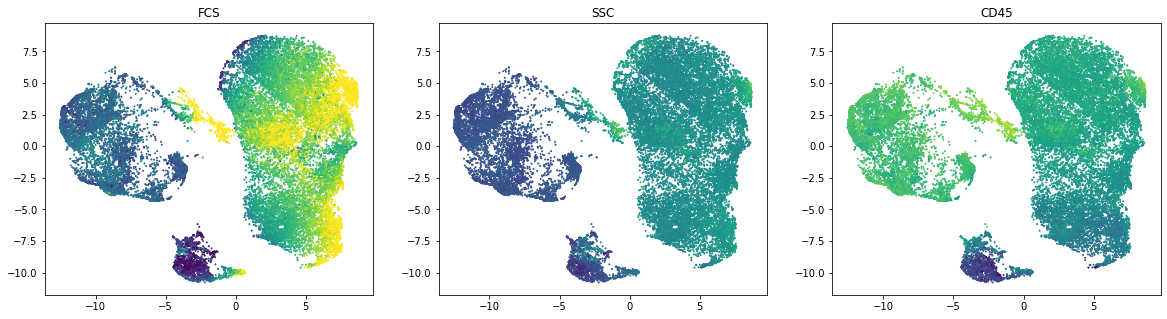

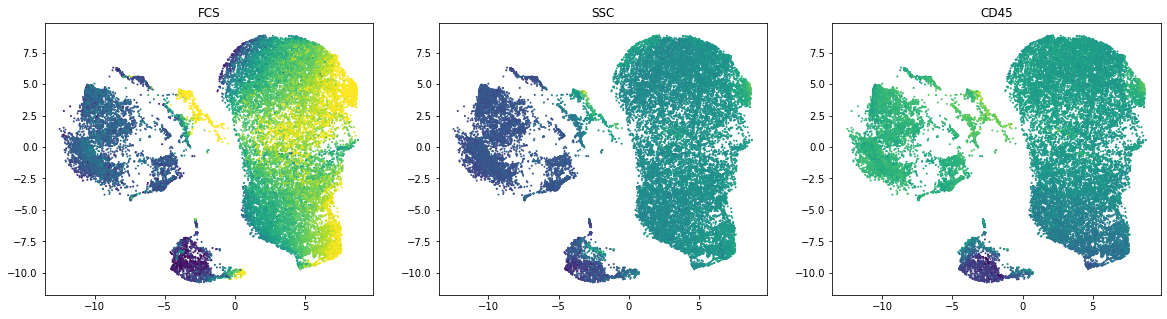

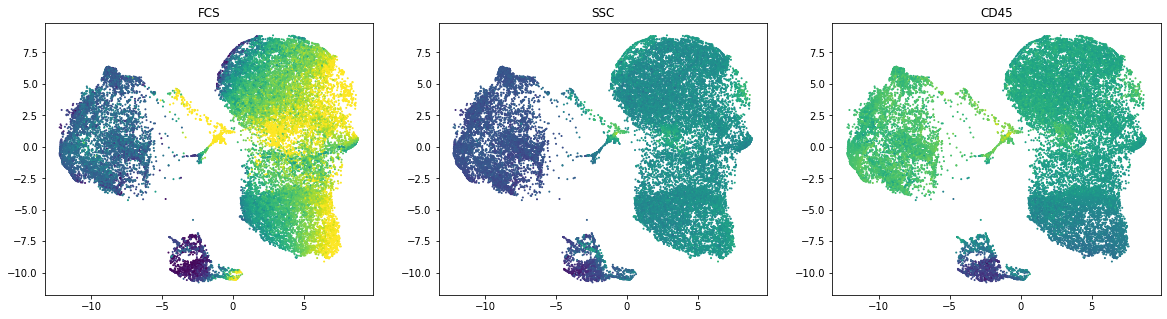

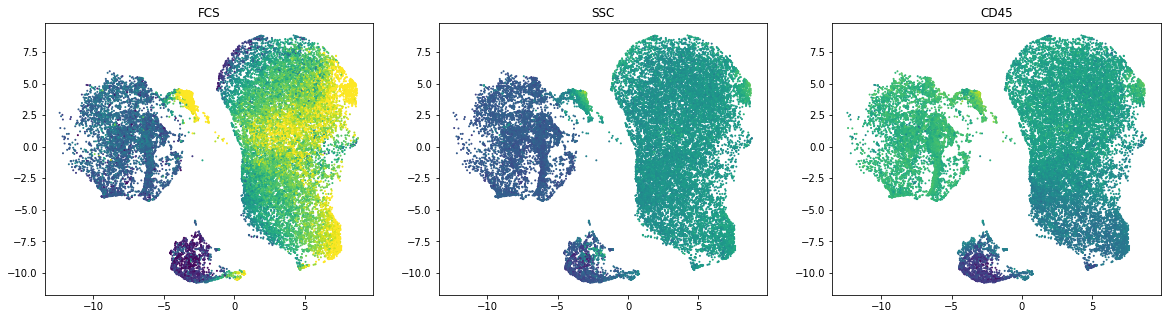

In [45]:
latents = []

trainer.vae.eval()
for i in range(n_head):
    data = Variable(torch.from_numpy(datasets[i][0].to_numpy()), requires_grad=False)
    latents.append(model.get_z(data.float(), i).data.numpy())
latent2d = UMAP().fit_transform(np.concatenate(latents))

plot_joint_aml(trainer, latent2d, latents)
plot_shared_markers_aml(trainer, latent2d, latents, datasets)

## 5. Imputation

NameError: name 'cms1' is not defined

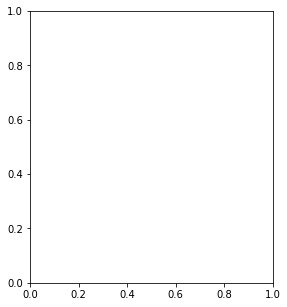

In [56]:
# marker names 
from matplotlib import pyplot as plt

def get_imputed_values(model, all_data, head_id):
    imputed_values = []
    for i, batch in enumerate(all_data):
        imputed,_ ,_ = model(batch.float(), head_id)
        imputed_values.append(imputed)
    imputed = torch.cat(imputed_values).detach().cpu().numpy()
    return imputed

def plot_imputed_values_test(trainer, tube_id, latent2d, latents, datasets, titles, save_name=None):
    n_tubes = trainer.n_tubes
    imputed = []
    for i in range(n_tubes):
        if i != tube_id:
            imputed.append(get_imputed_values(trainer.vae, datasets[i][5], i))

    cms1 = ["Greens", "Blues", "Reds", "Oranges"]
    
# now true values are plotted in the middle
fig = plt.figure(figsize=(20,5))
for k in range(1,5):
    zs = latent2d[tube_id*latents[tube_id].shape[0] : (tube_id+1)*latents[tube_id].shape[0]]
    plt.subplot(1,4,k)
    t = datasets[tube_id][0].iloc[:,2+tube_id*4+k]
    plt.scatter(zs[:,0], zs[:, 1], c=t, s=1, cmap=cms1[k-1])
    plt.title(titles[k-1]) 
latent2d = np.delete(latent2d, np.s_[tube_id*latents[tube_id].shape[0] : (tube_id+1)*latents[tube_id].shape[0]], 0)
for i in range(len(imputed)):
    fig = plt.figure(figsize=(20,5))
    for j in range(1,5):
        zs = latent2d[i*latents[i].shape[0] : (i+1)*latents[i].shape[0]]
        plt.subplot(1,4,j)
        t = imputed[i][:, 2+tube_id*4+j]
        plt.scatter(zs[:,0], zs[:, 1], c=t, s=1, cmap=cms1[j-1])
        plt.title(titles[j-1])

files = glob.glob(filepath1 + "*.txt")
titles = []
for i in range(len(files)):
    fcs = files[i][-8:-4]
    fcs_path = '/scratch/cs/csb/projects/single-cell-analysis/FCM/AML_FCM/Data/AML/FCS/'+fcs+'.FCS'
    sample = fk.Sample(fcs_path, subsample_count=None)
    features = sample.pns_labels[2:7]
    features.pop(2)
    titles.append(features)
print(titles) 
# visualize one set of imputed values, change later
#plot_imputed_values(trainer, latent2d, latents, datasets, titles)
tube_id = 0
plot_imputed_values_test(trainer, tube_id, latent2d, latents, datasets, titles[tube_id])

## 6. Validation metrics

In [5]:
# Comparison: accuracy and log p(y)?

def validation_accuracy(model, discriminator, test_iterators):
    model.eval()
    discriminator.eval()
    probs = []
    for tensors in test_iterators:
        ps = []
        for head_id, batch in enumerate(tensors):
            z = model.get_z(batch.float(), head_id)
            p = discriminator.classify(z)
            ps.append(p)
        pr = torch.cat(ps).cpu().detach().numpy()
        probs.append(pr)
    return probs

def validation_loss(test_iterators, model, input_dim_list):
    # set the evaluation mode
    model.eval()
    n_head = len(input_dim_list)
    # test loss for the data
    test_losses = []
    
    for tensors in test_iterators:
        for head_id, x in enumerate(tensors): 
            # reshape the data
            x = x.view(-1, input_dim_list[head_id]) 
            x = x.float()
            x = x.to(device)

            # forward pass
            x_sample, z_mu, z_var = model(x, head_id)

            loss, recs, kls = model.loss(x_sample, x, z_mu, z_var, head_id)
            test_losses.append(loss)
    sum_loss = torch.stack(test_losses).sum()

    return sum_loss

runs = 5
accuracies = []
val_losses = []
for i in range(runs):
    trainer.train()
    acc = validation_accuracy(model, discriminator, zip(*test_iterators))
    acc = [item for sublist in acc for item in sublist]
    acc = [item for sublist in acc for item in sublist]

    correct = 0
    probs1 = acc[::2]
    for i in probs1[:N_test]:
        if i > 0.5:
            correct += 1
    for i in probs1[N_test:]:
        if i < 0.5:
            correct += 1

    accuracy = correct/len(acc[::2])
    accuracies.append(accuracy)
    val_loss = validation_loss(zip(*test_iterators), model, input_dim_list)/N_test
    val_losses.append(val_loss)
print(accuracies)
print(val_losses)

04/03/2020 16:26:14 [INFO]: TRAINING STARTED (n_epochs = 30).
04/03/2020 16:26:39 [INFO]: Epoch: 00, VAE loss: (65.00318, 26.62234), Discriminator loss: (0.15395, 0.19281)
04/03/2020 16:26:57 [INFO]: Epoch: 01, VAE loss: (31.57738, 21.0753), Discriminator loss: (0.08514, 0.18994)
04/03/2020 16:27:16 [INFO]: Epoch: 02, VAE loss: (28.27621, 22.17976), Discriminator loss: (0.06751, 0.20976)
04/03/2020 16:27:34 [INFO]: Epoch: 03, VAE loss: (26.05268, 20.11083), Discriminator loss: (0.06428, 0.20041)
04/03/2020 16:27:52 [INFO]: Epoch: 04, VAE loss: (24.51838, 17.17264), Discriminator loss: (0.06096, 0.20311)
04/03/2020 16:28:10 [INFO]: Epoch: 05, VAE loss: (23.87543, 18.01659), Discriminator loss: (0.06067, 0.21299)
04/03/2020 16:28:29 [INFO]: Epoch: 06, VAE loss: (22.92946, 15.04566), Discriminator loss: (0.06395, 0.20623)
04/03/2020 16:28:47 [INFO]: Epoch: 07, VAE loss: (22.3499, 15.33871), Discriminator loss: (0.06112, 0.21148)
04/03/2020 16:29:05 [INFO]: Epoch: 08, VAE loss: (22.00009, 

04/03/2020 16:48:59 [INFO]: Epoch: 13, VAE loss: (15.2187, 14.19315), Discriminator loss: (0.12654, 0.2157)
04/03/2020 16:49:18 [INFO]: Epoch: 14, VAE loss: (15.2083, 12.12697), Discriminator loss: (0.12451, 0.21323)
04/03/2020 16:49:36 [INFO]: Epoch: 15, VAE loss: (15.24221, 11.91873), Discriminator loss: (0.13024, 0.21262)
04/03/2020 16:49:54 [INFO]: Epoch: 16, VAE loss: (15.04296, 12.1383), Discriminator loss: (0.12389, 0.21391)
04/03/2020 16:50:12 [INFO]: Epoch: 17, VAE loss: (15.15402, 13.37746), Discriminator loss: (0.12718, 0.20618)
04/03/2020 16:50:31 [INFO]: Epoch: 18, VAE loss: (15.01384, 13.14193), Discriminator loss: (0.13036, 0.21791)
04/03/2020 16:50:49 [INFO]: Epoch: 19, VAE loss: (14.95831, 12.96096), Discriminator loss: (0.12966, 0.20822)
04/03/2020 16:51:07 [INFO]: Epoch: 20, VAE loss: (15.01014, 12.13726), Discriminator loss: (0.12885, 0.21201)
04/03/2020 16:51:25 [INFO]: Epoch: 21, VAE loss: (15.05257, 13.67143), Discriminator loss: (0.13427, 0.21102)
04/03/2020 16:

In [6]:
print(np.mean(accuracies))
print(torch.mean(torch.stack(val_losses)))

0.5005666666666667
tensor(13.6274, grad_fn=<MeanBackward0>)
